In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv


In [2]:
#  Import and read the data 
train = pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv')
test=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv')
subm=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv')


In [3]:
#Drop the non-beneficial ID columns and assign ID column as labels
def set_index (df):
    df.set_index('id', inplace=True)
    return df

train_df=set_index(train)
test_df=set_index(test)

# Data Exploration

In [4]:
# Checking the datatypes for train dataset
train_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [5]:
test_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
dtype: object

In [6]:
#Determine the number of unique values in each column
def dataset_unique_counts(df):
    unique_counts = df.nunique()
    print(unique_counts)

In [7]:
#Unique values for train dataset
dataset_unique_counts(train_df)

brand             53
model           1827
model_year        34
milage          3212
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
price           1481
dtype: int64


In [8]:
#Unique values for test dataset
dataset_unique_counts(test_df)

brand             53
model           1791
model_year        34
milage          2973
fuel_type          7
engine          1038
transmission      44
ext_col          230
int_col          111
accident           2
clean_title        1
dtype: int64


In [9]:
def price_plot(df):
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=df, y='price', jitter=True, color='purple', alpha=0.5)
    plt.title('Strip Plot: Price Distribution')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


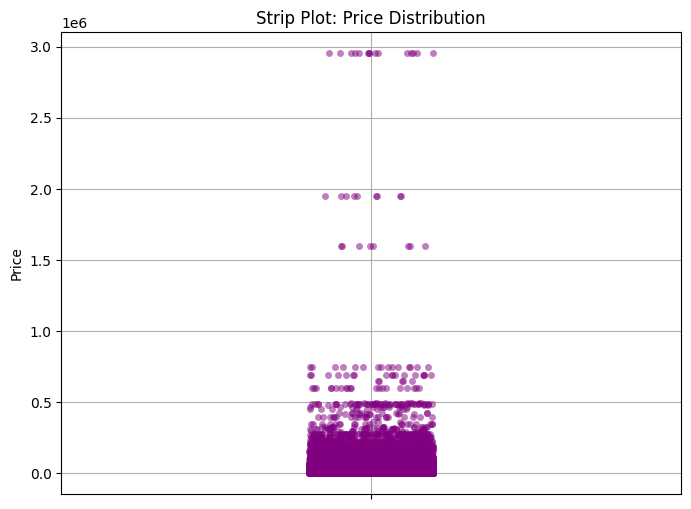

In [10]:
price_plot(train_df)

Above Histogram shows that most cars lie in the lower range of price.
The above graph has outliers from 0.4 onwards, which need to be removed.

In [11]:
#Train data needs to be cleaned from outliers
train_df['price'].describe()


count    5.427300e+04
mean     3.921844e+04
std      7.282634e+04
min      2.000000e+03
25%      1.550000e+04
50%      2.800000e+04
75%      4.500000e+04
max      2.954083e+06
Name: price, dtype: float64

In [12]:
#identify and remove outliers from the data df in relation to price column using IQR method
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

29500.0


In [13]:
#use IQR value to filter out the outliers
outliersfree_df = train_df[~((train_df['price'] < (Q1 - 1.5 * IQR)) |(train_df['price'] > (Q3 + 0.7 * IQR)))]
outliersfree_df.shape

(47678, 12)

The above plot looks more homogeneous than the previous one after removal of outliers.

In [14]:
#Train data needs to be cleaned from outliers
outliersfree_df['price'].describe()

count    47678.000000
mean     26943.079219
std      15404.132778
min       2000.000000
25%      14500.000000
50%      24900.000000
75%      37475.500000
max      65500.000000
Name: price, dtype: float64

# **Data wrangling**

I will reduce the number of features in string data categories, and will remain the numeric categories as they are.

In [15]:
#Determine the number of unique values in each column.
dataset_unique_counts(outliersfree_df)

brand             51
model           1795
model_year        34
milage          3093
fuel_type          7
engine          1045
transmission      43
ext_col          245
int_col          118
accident           2
clean_title        1
price           1108
dtype: int64


In [16]:
#Determine the number of unique values in each column.
dataset_unique_counts(test_df)

brand             53
model           1791
model_year        34
milage          2973
fuel_type          7
engine          1038
transmission      44
ext_col          230
int_col          111
accident           2
clean_title        1
dtype: int64


***Model cleaning***

In [17]:
# Value counts function 
def feature_value_counts(df, column_name):
    value_counts = df[column_name].value_counts()
    return value_counts

Brand feature

In [18]:
brand_counts_train = feature_value_counts(outliersfree_df, 'brand')
brand_counts_test = feature_value_counts(test_df, 'brand')

cutoff_value = 400 # Keep if database has 451 and more records of this car model
brand_types_to_replace = brand_counts_train[brand_counts_train < cutoff_value].index

# Replace models in the training dataframe
for brand_c in brand_types_to_replace:
    outliersfree_df.loc[outliersfree_df['brand'] == brand_c, 'brand'] = "Other"

# Apply the same replacements to the test dataframe
test_df.loc[test_df['brand'].isin(brand_types_to_replace), 'brand'] = "Other"
test_df.loc[~test_df['brand'].isin(outliersfree_df['brand'].unique()), 'brand'] = "Other"

# Check the updated value counts
brand_counts_train_updated = outliersfree_df['brand'].value_counts()
brand_counts_test_updated = test_df['brand'].value_counts()


*Model feature*

In [19]:
model_counts_train = feature_value_counts(outliersfree_df, 'model')
model_counts_test = feature_value_counts(test_df, 'model')

cutoff_value = 400 # Keep if database has 451 and more records of this car model
model_types_to_replace = model_counts_train[model_counts_train < cutoff_value].index

# Replace models in the training dataframe
for model_c in model_types_to_replace:
    outliersfree_df.loc[outliersfree_df['model'] == model_c, 'model'] = "Other"

# Apply the same replacements to the test dataframe
test_df.loc[test_df['model'].isin(model_types_to_replace), 'model'] = "Other"
test_df.loc[~test_df['model'].isin(outliersfree_df['model'].unique()), 'model'] = "Other"

# Check the updated value counts
model_counts_train_updated = outliersfree_df['model'].value_counts()
model_counts_test_updated = test_df['model'].value_counts()


*Fuel feature*

In [20]:
# Replace '–' with 'Other' in the 'fuel_type' column
def cleaning_not_supported_and_dashes(df):
    # Replace unsupported dashes with 'Other'
    df.loc[df['fuel_type'] == '–', 'fuel_type'] = 'Other'
    # Remove rows where 'fuel_type' is 'not supported'
    cleaned_df = df[df['fuel_type'] != 'not supported']
    # Calculate and return the value counts of the cleaned 'fuel_type' column
    fuel_counts = cleaned_df['fuel_type'].value_counts()
    return cleaned_df

In [21]:
cleaned_train=cleaning_not_supported_and_dashes(outliersfree_df)
feature_value_counts(cleaned_train, 'fuel_type')

fuel_type
Gasoline          43613
E85 Flex Fuel      1435
Hybrid             1323
Diesel              889
Other               266
Plug-In Hybrid      148
Name: count, dtype: int64

In [22]:
cleaned_test=cleaning_not_supported_and_dashes(test_df)
feature_value_counts(cleaned_test, 'fuel_type')

fuel_type
Gasoline          33033
Hybrid             1112
E85 Flex Fuel      1018
Diesel              671
Other               197
Plug-In Hybrid      148
Name: count, dtype: int64

*Engine feature*

In [23]:
#Reducing the features unique values
engine_counts_train = feature_value_counts(cleaned_train, 'engine')
engine_counts_test = feature_value_counts(cleaned_test, 'engine')

cutoff_value = 400 # Keep if database has 451 and more records of this car model
engine_types_to_replace = engine_counts_train[engine_counts_train < cutoff_value].index

# Replace models in the training dataframe
for engine_c in engine_types_to_replace:
    cleaned_train.loc[cleaned_train['engine'] == engine_c, 'engine'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['engine'].isin(engine_types_to_replace), 'engine'] = "Other"
cleaned_test.loc[~cleaned_test['engine'].isin(cleaned_train['engine'].unique()), 'engine'] = "Other"

# Check the updated value counts
engine_counts_train_updated = cleaned_train['engine'].value_counts()
engine_counts_test_updated = cleaned_test['engine'].value_counts()


*Transmission feature*

In [24]:
#Reducing the features unique values
trans_counts_train = feature_value_counts(cleaned_train, 'transmission')
trans_counts_test = feature_value_counts(cleaned_test, 'transmission')

cutoff_value = 100 # Keep if database has 451 and more records of this car model
trans_types_to_replace = trans_counts_train[trans_counts_train < cutoff_value].index

# Replace models in the training dataframe
for trans_c in trans_types_to_replace:
    cleaned_train.loc[cleaned_train['transmission'] == trans_c, 'transmission'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['transmission'].isin(trans_types_to_replace), 'transmission'] = "Other"
cleaned_test.loc[~cleaned_test['transmission'].isin(cleaned_train['transmission'].unique()), 'transmission'] = "Other"

# Check the updated value counts
trans_counts_train_updated = cleaned_train['transmission'].value_counts()
trans_counts_test_updated = cleaned_test['transmission'].value_counts()


*External colour feature*

In [25]:
#Reducing the features unique values
ext_col_counts_train = feature_value_counts(cleaned_train, 'ext_col')
ext_col_counts_test = feature_value_counts(cleaned_test, 'ext_col')

cutoff_value = 1000 # Keep if database has 451 and more records of this car model
ext_col_types_to_replace =ext_col_counts_train[ext_col_counts_train < cutoff_value].index

# Replace models in the training dataframe
for ext_col_c in ext_col_types_to_replace:
    cleaned_train.loc[cleaned_train['ext_col'] == ext_col_c, 'ext_col'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['ext_col'].isin(ext_col_types_to_replace), 'ext_col'] = "Other"
cleaned_test.loc[~cleaned_test['ext_col'].isin(cleaned_train['ext_col'].unique()), 'ext_col'] = "Other"

# Check the updated value counts
ext_col_counts_train_updated = cleaned_train['ext_col'].value_counts()
ext_col_counts_test_updated = cleaned_test['ext_col'].value_counts()

*Internal colour feature*

In [26]:
#Reducing the features unique values
int_col_counts_train = feature_value_counts(cleaned_train, 'int_col')
int_col_counts_test = feature_value_counts(cleaned_test, 'int_col')

cutoff_value = 1050 # Keep if database has 451 and more records of this car model
int_col_types_to_replace =int_col_counts_train[int_col_counts_train < cutoff_value].index

# Replace models in the training dataframe
for int_col_c in int_col_types_to_replace:
    cleaned_train.loc[cleaned_train['int_col'] == int_col_c, 'int_col'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['int_col'].isin(int_col_types_to_replace), 'int_col'] = "Other"
cleaned_test.loc[~cleaned_test['int_col'].isin(cleaned_train['int_col'].unique()), 'int_col'] = "Other"

# Check the updated value counts
int_col_counts_train_updated = cleaned_train['int_col'].value_counts()
int_col_counts_test_updated = cleaned_test['int_col'].value_counts()

*Drop clean title that has only one value 'clean_title'*

In [27]:
#The last column "Clean_title" is the same "Yes" answer for all rows, that gives no value to analysis. 
#Drop this column.
final_train=cleaned_train.drop(columns=['clean_title'])
final_test=cleaned_test.drop(columns=['clean_title'])


In [28]:
dataset_unique_counts(final_train)

brand             27
model              6
model_year        34
milage          3093
fuel_type          6
engine            18
transmission      19
ext_col            7
int_col            6
accident           2
price           1108
dtype: int64


In [29]:
dataset_unique_counts(final_test)

brand             27
model              6
model_year        34
milage          2973
fuel_type          6
engine            18
transmission      19
ext_col            7
int_col            6
accident           2
dtype: int64


***Liner Regression***

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
# Convert categorical data to numeric with `pd.get_dummies`
X = pd.get_dummies(final_train)
X.shape


(47674, 94)

In [32]:
# Convert categorical data to numeric with `pd.get_dummies`
X_test = pd.get_dummies(final_test)
X_test.shape


(36179, 93)

In [33]:
# Split our preprocessed data into our features and target arrays
y=X['price'].values.reshape(-1, 1)

In [34]:
#Removing the price from the prediction features
X = X.drop(['price'], axis=1)
X.shape

(47674, 93)

In [35]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

In [36]:
#make predictions train
yhat = lm.predict(X)
yhat[0:5]

array([[41873.09637451],
       [15701.23382568],
       [19036.22875977],
       [48699.51989746],
       [ 7557.17590332]])

In [37]:
#find the intercept
lm.intercept_

array([-3.81357569e+11])

In [38]:
#find the slope
lm.coef_

array([[ 1.03959621e+03, -9.85426584e-02,  3.15709358e+10,
         3.15709380e+10,  3.15709409e+10,  3.15709370e+10,
         3.15709399e+10,  3.15709393e+10,  3.15709396e+10,
         3.15709375e+10,  3.15709370e+10,  3.15709327e+10,
         3.15709367e+10,  3.15709411e+10,  3.15709376e+10,
         3.15709340e+10,  3.15709417e+10,  3.15709403e+10,
         3.15709396e+10,  3.15709347e+10,  3.15709414e+10,
         3.15709362e+10,  3.15709375e+10,  3.15709426e+10,
         3.15709413e+10,  3.15709342e+10,  3.15709408e+10,
         3.15709337e+10,  3.15709372e+10, -1.28403372e+10,
        -1.28403407e+10, -1.28403377e+10, -1.28403407e+10,
        -1.28403404e+10, -1.28403401e+10,  1.95168181e+11,
         1.95168173e+11,  1.95168172e+11,  1.95168172e+11,
         1.95168178e+11,  1.95168170e+11, -1.75769273e+10,
        -1.75769292e+10, -1.75769314e+10, -1.75769284e+10,
        -1.75769302e+10, -1.75769218e+10, -1.75769238e+10,
        -1.75769298e+10, -1.75769301e+10, -1.75769232e+1

In [39]:
#find the MSE
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(y, yhat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 100875230.18026106


In [40]:
#find the RMSE
rmse = np.sqrt(mse)
rmse

10043.666172282961

In [41]:
#find rscore
from sklearn.metrics import r2_score
r2_score(y, yhat)

0.5748755539105683

Given the statistics of the "price" variable:

Comparison to Mean: The RMSE (10,043.67) is a significant portion of the mean price (26,943.08). Specifically, it's about 37.3% of the mean.
Comparison to Standard Deviation: The RMSE is also a substantial portion of the standard deviation (15,404.13), around 65.2%.
Range: The price data ranges from 2,000 to 65,500, giving a total range of 63,500. The RMSE (10,043.67) is about 15.8% of this range.
Interpretation:
High RMSE: The RMSE of 10,043.67 suggests that the model's predictions have a relatively high average error compared to the mean price. This could indicate that the model has room for improvement, especially if lower prediction errors are desirable for the given context.
Impact on Predictions: For prices around the mean value, an error of 10,043.67 is quite significant. This means that for a typical house priced around 26,943, the predicted price could vary by ±10,043.67 on average, which might be too large depending on the use case.
Relative Error: Given the standard deviation and the interquartile range (IQR = 37,475.5 - 14,500 = 22,975.5), the RMSE is quite high. This suggests that the model might not be capturing the variance in the data well.

***XGBRegressor***

In [42]:
from xgboost import XGBRegressor

In [43]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X,y)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-11062.988 total time=   1.5s
[CV 2/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-11261.549 total time=   1.5s
[CV 3/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-11041.588 total time=   1.4s
[CV 1/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 1/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-9716.628 total time=   3.9s
[CV 2/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 2/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-9958.562 total time=   4.7s


In [44]:
train_prediction=best_model.predict(X)

In [45]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y)
mae_train=metrics.mean_absolute_error(train_prediction,y)
rmse_train=metrics.mean_squared_error(train_prediction,y,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
print(train_scores)

{'R2_train': 0.4673693475383335, 'MAE_train': 6652.780736584668, 'RMSE_train': 8965.993303190306}


# Validation with test data

In [46]:
#make predictions test
test_prediction=best_model.predict(X_test)
test_prediction

array([19371.71 , 23231.467, 36089.152, ..., 12225.616, 46245.383,
       12903.699], dtype=float32)